In [1]:
from nltk.corpus import stopwords

# Download stopwords if not already downloaded
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Define the stopwords set
STOPWORDS = set(stopwords.words('english'))

In [3]:
# prompt: connect to drive

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import numpy as np
import pandas as pd
import re
import math
from collections import Counter
from sklearn.model_selection import train_test_split

# ----------------------------
# 1. Data Preprocessing
# ----------------------------

def clean_text(text):
    """Lowercase and remove non-alphanumeric characters."""
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text

def tokenize(text):
    """Split text by whitespace and remove stopwords."""
    tokens = text.split()
    # Remove stopwords
    tokens = [token for token in tokens if token not in STOPWORDS]
    return tokens

def build_vocabulary(documents, max_features=5000):
    """Build vocabulary of the top max_features tokens from the documents."""
    counter = Counter()
    for doc in documents:
        tokens = tokenize(doc)
        counter.update(tokens)
    vocab = {word: i for i, (word, _) in enumerate(counter.most_common(max_features))}
    return vocab

def compute_idf(documents, vocab):
    """Compute inverse document frequency for each word in vocab."""
    N = len(documents)
    df = np.zeros(len(vocab))
    for doc in documents:
        tokens = set(tokenize(doc))
        for token in tokens:
            if token in vocab:
                df[vocab[token]] += 1
    idf = np.log((N + 1) / (df + 1)) + 1
    return idf

def compute_tf_idf(documents, vocab, idf):
    """Compute TF-IDF for each document given a vocabulary and idf vector."""
    X = np.zeros((len(documents), len(vocab)))
    for i, doc in enumerate(documents):
        tokens = tokenize(doc)
        if len(tokens) == 0:
            continue
        tf_counter = Counter(tokens)
        total_count = len(tokens)
        for token, count in tf_counter.items():
            if token in vocab:
                j = vocab[token]
                tf = count / total_count
                X[i, j] = tf * idf[j]
    return X

def multi_label_binarize(labels_list):
    """Convert list of comma-separated labels to a binary matrix."""
    label_set = set()
    split_labels = []
    for labels in labels_list:
        topics = [label.strip() for label in labels.split(',') if label.strip()]
        split_labels.append(topics)
        label_set.update(topics)
    label_list = sorted(list(label_set))
    label_mapping = {label: idx for idx, label in enumerate(label_list)}
    Y = np.zeros((len(labels_list), len(label_list)))
    for i, topics in enumerate(split_labels):
        for topic in topics:
            if topic in label_mapping:
                Y[i, label_mapping[topic]] = 1
    return Y, label_mapping

def preprocess_data(csv_path, max_features=5000, test_size=0.2):
    """Load CSV, clean documents, compute TF-IDF, binarize labels,
       and split into training and validation sets."""
    df = pd.read_csv(csv_path)
    df.dropna(subset=['document', 'category'], inplace=True)
    df['document'] = df['document'].apply(clean_text)

    documents = df['document'].tolist()
    labels_list = df['category'].tolist()

    vocab = build_vocabulary(documents, max_features=max_features)
    idf = compute_idf(documents, vocab)
    X = compute_tf_idf(documents, vocab, idf)
    Y, label_mapping = multi_label_binarize(labels_list)

    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=test_size, random_state=42)
    return X_train, X_val, Y_train, Y_val, vocab, label_mapping

# ----------------------------
# 2. Metrics for Multi-Label Classification
# ----------------------------

def compute_hamming_loss(y_true, y_pred):
    """Compute Hamming loss: fraction of misclassified labels."""
    return np.mean(np.not_equal(y_true, y_pred))

def compute_accuracy(y_true, y_pred):
    """Compute subset (exact match) accuracy for multi-label classification."""
    return np.mean(np.all(y_true == y_pred, axis=1))

# ----------------------------
# 3. MLP Model Development
# ----------------------------

# Activation functions and derivatives
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_deriv(a):
    return a * (1 - a)

def tanh(z):
    return np.tanh(z)

def tanh_deriv(a):
    return 1 - np.power(a, 2)

def relu(z):
    return np.maximum(0, z)

def relu_deriv(z):
    return np.array(z > 0, dtype=float)

# Configurable MLP class
class MLP:
    def __init__(self, input_size, output_size, hidden_layers=[100],
                 activation='relu', learning_rate=0.01, optimizer='sgd',verbose=True):
        """
        input_size: number of input features
        output_size: number of output neurons (labels)
        hidden_layers: list with the number of neurons in each hidden layer
        activation: 'sigmoid', 'tanh', or 'relu' for hidden layers
        learning_rate: learning rate for gradient descent
        optimizer: 'sgd', 'batch', or 'minibatch'
        verbose: whether to print training progress
        """
        self.verbose = verbose
        self.learning_rate = learning_rate
        self.optimizer = optimizer.lower()
        if activation.lower() == 'sigmoid':
            self.activation_func = sigmoid
            self.activation_deriv = sigmoid_deriv
        elif activation.lower() == 'tanh':
            self.activation_func = tanh
            self.activation_deriv = tanh_deriv
        elif activation.lower() == 'relu':
            self.activation_func = relu
            self.activation_deriv = relu_deriv
        else:
            raise ValueError("Unsupported activation function")

        layer_sizes = [input_size] + hidden_layers + [output_size]
        self.num_layers = len(layer_sizes)
        self.weights = []
        self.biases = []
        for i in range(self.num_layers - 1):
            W = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(2 / layer_sizes[i])
            b = np.zeros((1, layer_sizes[i+1]))
            self.weights.append(W)
            self.biases.append(b)

    def forward(self, X):
        """Forward propagation. Returns lists of activations and linear outputs."""
        a = X
        activations = [a]
        zs = []  # linear outputs
        for i in range(len(self.weights) - 1):
            z = np.dot(a, self.weights[i]) + self.biases[i]
            a = self.activation_func(z)
            zs.append(z)
            activations.append(a)
        z = np.dot(a, self.weights[-1]) + self.biases[-1]
        a = sigmoid(z)  # using sigmoid for multi-label binary classification
        zs.append(z)
        activations.append(a)
        return activations, zs

    def compute_loss(self, Y_hat, Y):
        """Binary cross-entropy loss."""
        m = Y.shape[0]
        epsilon = 1e-8
        loss = -np.sum(Y * np.log(Y_hat + epsilon) + (1 - Y) * np.log(1 - Y_hat + epsilon)) / m
        return loss

    def backward(self, activations, zs, X, Y):
        """Backpropagation to compute gradients."""
        m = Y.shape[0]
        grads_W = [None] * len(self.weights)
        grads_b = [None] * len(self.biases)

        aL = activations[-1]
        delta = (aL - Y)  # For binary cross-entropy with sigmoid output
        grads_W[-1] = np.dot(activations[-2].T, delta) / m
        grads_b[-1] = np.sum(delta, axis=0, keepdims=True) / m

        for l in range(2, self.num_layers):
            z = zs[-l]
            if self.activation_func == relu:
                d_activation = relu_deriv(z)
            else:
                d_activation = self.activation_deriv(activations[-l])
            delta = np.dot(delta, self.weights[-l+1].T) * d_activation
            grads_W[-l] = np.dot(activations[-l-1].T, delta) / m
            grads_b[-l] = np.sum(delta, axis=0, keepdims=True) / m

        return grads_W, grads_b

    def update_parameters(self, grads_W, grads_b):
        """Update parameters using gradient descent."""
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * grads_W[i]
            self.biases[i] -= self.learning_rate * grads_b[i]

    def train(self, X, Y, epochs=100, batch_size=32, X_val=None, Y_val=None):
        """Train the MLP and report loss, Hamming loss, and accuracy metrics."""
        m = X.shape[0]
        history = {
            'loss': [],
            'train_hamming_loss': [],
            'train_accuracy': [],
            'val_loss': [],
            'val_hamming_loss': [],
            'val_accuracy': []
        }

        for epoch in range(epochs):
            indices = np.arange(m)
            np.random.shuffle(indices)
            X_shuffled = X[indices]
            Y_shuffled = Y[indices]

            if self.optimizer == 'batch':
                activations, zs = self.forward(X_shuffled)
                loss = self.compute_loss(activations[-1], Y_shuffled)
                grads_W, grads_b = self.backward(activations, zs, X_shuffled, Y_shuffled)
                self.update_parameters(grads_W, grads_b)
            elif self.optimizer == 'sgd':
                losses = []
                for i in range(m):
                    xi = X_shuffled[i:i+1]
                    yi = Y_shuffled[i:i+1]
                    activations, zs = self.forward(xi)
                    loss_i = self.compute_loss(activations[-1], yi)
                    losses.append(loss_i)
                    grads_W, grads_b = self.backward(activations, zs, xi, yi)
                    self.update_parameters(grads_W, grads_b)
                loss = np.mean(losses)
            elif self.optimizer == 'minibatch':
                num_batches = int(np.ceil(m / batch_size))
                losses = []
                for i in range(num_batches):
                    start = i * batch_size
                    end = min(start + batch_size, m)
                    xi = X_shuffled[start:end]
                    yi = Y_shuffled[start:end]
                    activations, zs = self.forward(xi)
                    loss_i = self.compute_loss(activations[-1], yi)
                    losses.append(loss_i)
                    grads_W, grads_b = self.backward(activations, zs, xi, yi)
                    self.update_parameters(grads_W, grads_b)
                loss = np.mean(losses)
            else:
                raise ValueError("Unsupported optimizer type")

            # Compute training metrics on the entire training set
            train_preds = self.predict(X)
            train_hamming = compute_hamming_loss(Y, train_preds)
            train_acc = compute_accuracy(Y, train_preds)

            history['loss'].append(loss)
            history['train_hamming_loss'].append(train_hamming)
            history['train_accuracy'].append(train_acc)

            # Compute validation metrics if available
            if X_val is not None and Y_val is not None:
                val_preds = self.predict(X_val)
                val_loss = self.compute_loss(self.forward(X_val)[0][-1], Y_val)
                val_hamming = compute_hamming_loss(Y_val, val_preds)
                val_acc = compute_accuracy(Y_val, val_preds)
                history['val_loss'].append(val_loss)
                history['val_hamming_loss'].append(val_hamming)
                history['val_accuracy'].append(val_acc)
                if self.verbose:
                    print(f"Epoch {epoch+1}/{epochs} - loss: {loss:.4f} - train_hamming: {train_hamming:.4f} - train_acc: {train_acc:.4f} - val_loss: {val_loss:.4f} - val_hamming: {val_hamming:.4f} - val_acc: {val_acc:.4f}")
            else:
              if self.verbose:
                    print(f"Epoch {epoch+1}/{epochs} - loss: {loss:.4f} - train_hamming: {train_hamming:.4f} - train_acc: {train_acc:.4f}")
        return history

    def predict(self, X, threshold=0.5):
        """Predict multi-label outputs using the trained model."""
        activations, _ = self.forward(X)
        predictions = (activations[-1] >= threshold).astype(int)
        return predictions



In [6]:
# ----------------------------
# 4. Testing on Test Data
# ----------------------------

def preprocess_test_data(csv_path, vocab, idf):
    """
    Preprocess test data using the same vocabulary and idf computed from training data.
    Assumes test CSV has at least a "document" column.
    Returns a tuple: (X_test, df, Y_test). Y_test will be None if the 'category' column is missing.
    """
    df = pd.read_csv(csv_path)
    df.dropna(subset=['document'], inplace=True)
    df['document'] = df['document'].apply(clean_text)
    documents = df['document'].tolist()
    X_test = compute_tf_idf(documents, vocab, idf)
    Y_test = None
    if 'category' in df.columns:
        labels_list = df['category'].tolist()
        Y_test, _ = multi_label_binarize(labels_list)
    return X_test, df, Y_test

In [8]:
# Preprocessing and training as before:
csv_path = '/content/drive/MyDrive/news-article/train.csv'  # Path to your training CSV file
X_train, X_val, Y_train, Y_val, vocab, label_mapping = preprocess_data(csv_path, max_features=5000, test_size=0.2)

# 'idf' computed during training:
documents_train = pd.read_csv(csv_path)['document'].dropna().apply(clean_text).tolist()
idf = compute_idf(documents_train, vocab)

input_size = X_train.shape[1]
output_size = Y_train.shape[1]

mlp = MLP(input_size=input_size, output_size=output_size,
        hidden_layers=[256,128,64], activation='relu', learning_rate=0.01, optimizer='minibatch')

history = mlp.train(X_train, Y_train, epochs=20, batch_size=32, X_val=X_val, Y_val=Y_val)

# --- Testing on new data ---
test_csv_path = '/content/drive/MyDrive/news-article/test.csv'  # Path to your test CSV file
X_test, df_test,Y_test = preprocess_test_data(test_csv_path, vocab, idf)

test_predictions = mlp.predict(X_test)
print("Sample predictions on test set:")
print(np.sum(test_predictions[:10],axis=1))

# Optional: If the test data has true labels in a "category" column, compute test metrics.
test_hamming = compute_hamming_loss(Y_test, test_predictions)
test_acc = compute_accuracy(Y_test, test_predictions)
print(f"Test Hamming Loss: {test_hamming:.4f}, Test Accuracy: {test_acc:.4f}")


Epoch 1/20 - loss: 10.4434 - train_hamming: 0.0137 - train_acc: 0.0000 - val_loss: 4.4636 - val_hamming: 0.0137 - val_acc: 0.0000
Epoch 2/20 - loss: 4.3953 - train_hamming: 0.0165 - train_acc: 0.3652 - val_loss: 4.4037 - val_hamming: 0.0164 - val_acc: 0.3668
Epoch 3/20 - loss: 4.3256 - train_hamming: 0.0116 - train_acc: 0.1879 - val_loss: 4.3383 - val_hamming: 0.0114 - val_acc: 0.2014
Epoch 4/20 - loss: 4.2346 - train_hamming: 0.0136 - train_acc: 0.0217 - val_loss: 4.3747 - val_hamming: 0.0136 - val_acc: 0.0187
Epoch 5/20 - loss: 4.0947 - train_hamming: 0.0111 - train_acc: 0.2367 - val_loss: 4.0068 - val_hamming: 0.0110 - val_acc: 0.2432
Epoch 6/20 - loss: 3.8771 - train_hamming: 0.0104 - train_acc: 0.3062 - val_loss: 3.8385 - val_hamming: 0.0103 - val_acc: 0.3179
Epoch 7/20 - loss: 3.7395 - train_hamming: 0.0104 - train_acc: 0.2961 - val_loss: 3.6936 - val_hamming: 0.0103 - val_acc: 0.3044
Epoch 8/20 - loss: 3.6373 - train_hamming: 0.0105 - train_acc: 0.2911 - val_loss: 3.6009 - val_h

In [9]:
#predicting classes
print(np.sum(test_predictions,axis=0))
print(label_mapping)

[ 680    0    0    0    0    0    0    0    0    0    0    0    3    0
    0    0    0    0    0    0    0 1030    0    0    0    0   93    0
    0    0    0    0    0    0    8    0    0    0    0    0    0    0
    0    0    0    0  123    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    3    0    0    0]
{'acq': 0, 'alum': 1, 'barley': 2, 'bop': 3, 'carcass': 4, 'castor-oil': 5, 'cocoa': 6, 'coconut': 7, 'coconut-oil': 8, 'coffee': 9, 'copper': 10, 'copra-cake': 11, 'corn': 12, 'cotton': 13, 'cotton-oil': 14, 'cpi': 15, 'cpu': 16, 'crude': 17, 'dfl': 18, 'dlr': 19, 'dmk': 20, 'earn': 21, 'fuel': 22, 'gas': 23, 'gnp': 24, 'gold': 25, 'grain': 26, 'groundnut': 27, 'groundnut-oil': 28, 'heat': 29, 'hog': 30, 'housing': 31, 'income': 32, 'instal-debt': 33, 'interest': 34, 'ipi': 35, 'iron-steel': 36, 'jet': 37, 'jobs': 38, 'l-cattle': 39, '

In [10]:
print("Total test predictions shape",test_predictions)
# Add this after getting predictions
print("Prediction statistics:")
print(f"Total predictions: {test_predictions.shape[0]}")
print(f"Zeros: {np.sum(test_predictions == 0)}")
print(f"Ones: {np.sum(test_predictions == 1)}")
print(f"Average predictions per sample: {np.mean(np.sum(test_predictions, axis=1))}")
print("\nSample of prediction sums per row:")
print(np.sum(test_predictions[:10], axis=1))  # Shows number of 1s in first 10 predictions

# Check if any row is all zeros
all_zero_rows = np.sum(test_predictions.sum(axis=1) == 0)
print(f"\nRows with all zeros: {all_zero_rows} out of {test_predictions.shape[0]}")

# Look at the raw probabilities before thresholding
activations, _ = mlp.forward(X_val)
final_layer_activations = activations[-1]
print("\nRaw probability statistics:")
print(f"Mean probability: {np.mean(final_layer_activations)}")
print(f"Max probability: {np.max(final_layer_activations)}")
print(f"Min probability: {np.min(final_layer_activations)}")

Total test predictions shape [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Prediction statistics:
Total predictions: 3019
Zeros: 269770
Ones: 1940
Average predictions per sample: 0.6425968863862206

Sample of prediction sums per row:
[0 0 0 0 0 0 0 1 0 0]

Rows with all zeros: 1101 out of 3019

Raw probability statistics:
Mean probability: 0.01766128074568985
Max probability: 0.9999999978510767
Min probability: 1.2335346628599618e-08


In [ ]:
import numpy as np

def preprocess_input(paragraph, vocab, idf):
    """
    Preprocess the input paragraph and compute its TF-IDF vector.

    Parameters:
        paragraph (str): Input paragraph to classify.
        vocab (dict): Vocabulary mapping words to indices.
        idf (np.ndarray): Precomputed IDF vector.

    Returns:
        np.ndarray: TF-IDF vector for the input paragraph.
    """
    # Clean and tokenize the input paragraph
    paragraph = clean_text(paragraph)
    tokens = tokenize(paragraph)

    # Compute TF-IDF for the input paragraph
    tf_counter = Counter(tokens)
    total_count = len(tokens)
    tf_idf_vector = np.zeros(len(vocab))
    for token, count in tf_counter.items():
        if token in vocab:
            j = vocab[token]
            tf = count / total_count
            tf_idf_vector[j] = tf * idf[j]

    return tf_idf_vector.reshape(1, -1)  # Reshape for model input


def predict_classes(paragraph, model, vocab, idf, label_mapping):
    """
    Predict the classes for a given input paragraph using the trained model.

    Parameters:
        paragraph (str): Input paragraph to classify.
        model: Trained MLP model.
        vocab (dict): Vocabulary mapping words to indices.
        idf (np.ndarray): Precomputed IDF vector.
        label_mapping (dict): Mapping of labels to indices.

    Returns:
        list: Predicted classes for the input paragraph.
    """
    # Preprocess the input paragraph
    tf_idf_vector = preprocess_input(paragraph, vocab, idf)

    # Predict probabilities using the trained model
    probabilities = model.predict(tf_idf_vector)

    # Threshold probabilities to determine classes (e.g., threshold = 0.5)
    threshold = 0.5
    predicted_indices = np.where(probabilities[0] >= threshold)[0]

    # Map indices back to class labels
    inverse_label_mapping = {idx: label for label, idx in label_mapping.items()}
    predicted_classes = [inverse_label_mapping[idx] for idx in predicted_indices]

    return predicted_classes


# Example usage
if __name__ == "__main__":
    # Example input paragraph
    input_paragraph = """INDONESIA SEES CPO PRICE RISING SHARPLY
  Indonesia expects crude palm oil (CPO)
  prices to rise sharply to between 450 and 550 dlrs a tonne FOB
  sometime this year because of better European demand and a fall
  in Malaysian output, Hasrul Harahap, junior minister for tree
  crops, told Indonesian reporters.
      Prices of Malaysian and Sumatran CPO are now around 332
  dlrs a tonne CIF for delivery in Rotterdam, traders said.
      Harahap said Indonesia would maintain its exports, despite
  making recent palm oil purchases from Malaysia, so that it
  could possibly increase its international market share.
      Indonesia, the world's second largest producer of palm oil
  after Malaysia, has been forced to import palm oil to ensure
  supplies during the Moslem fasting month of Ramadan.
      Harahap said it was better to import to cover a temporary
  shortage than to lose export markets.
      Indonesian exports of CPO in calendar 1986 were 530,500
  tonnes, against 468,500 in 1985, according to central bank
  figures.
  """

    # Assuming you have the following variables from your training pipeline:
    # - model: Trained MLP model
    # - vocab: Vocabulary dictionary
    # - idf: Precomputed IDF vector
    # - label_mapping: Label-to-index mapping

    # Predict classes for the input paragraph
    predicted_classes = predict_classes(input_paragraph, mlp, vocab, idf, label_mapping)
    print("Predicted Classes:", predicted_classes)
    print(label_mapping)

Predicted Classes: ['palm-oil', 'veg-oil']
{'acq': 0, 'alum': 1, 'barley': 2, 'bop': 3, 'carcass': 4, 'castor-oil': 5, 'cocoa': 6, 'coconut': 7, 'coconut-oil': 8, 'coffee': 9, 'copper': 10, 'copra-cake': 11, 'corn': 12, 'cotton': 13, 'cotton-oil': 14, 'cpi': 15, 'cpu': 16, 'crude': 17, 'dfl': 18, 'dlr': 19, 'dmk': 20, 'earn': 21, 'fuel': 22, 'gas': 23, 'gnp': 24, 'gold': 25, 'grain': 26, 'groundnut': 27, 'groundnut-oil': 28, 'heat': 29, 'hog': 30, 'housing': 31, 'income': 32, 'instal-debt': 33, 'interest': 34, 'ipi': 35, 'iron-steel': 36, 'jet': 37, 'jobs': 38, 'l-cattle': 39, 'lead': 40, 'lei': 41, 'lin-oil': 42, 'livestock': 43, 'lumber': 44, 'meal-feed': 45, 'money-fx': 46, 'money-supply': 47, 'naphtha': 48, 'nat-gas': 49, 'nickel': 50, 'nkr': 51, 'nzdlr': 52, 'oat': 53, 'oilseed': 54, 'orange': 55, 'palladium': 56, 'palm-oil': 57, 'palmkernel': 58, 'pet-chem': 59, 'platinum': 60, 'potato': 61, 'propane': 62, 'rand': 63, 'rape-oil': 64, 'rapeseed': 65, 'reserves': 66, 'retail': 67, 


=== Experiment: Activation=relu, Optimizer=minibatch, Learning Rate=0.01, Architecture=[128, 64], Epochs=10 ===
test_loss: 3.8194890969172195
test_hamming: 0.010297743918148026
test_accuracy: 0.3136800264988407

=== Experiment: Activation=relu, Optimizer=minibatch, Learning Rate=0.01, Architecture=[128, 64], Epochs=20 ===
test_loss: 3.3276204970040815
test_hamming: 0.009131058849508667
test_accuracy: 0.4203378602186154

=== Experiment: Activation=relu, Optimizer=minibatch, Learning Rate=0.01, Architecture=[256, 128, 64], Epochs=10 ===
test_loss: 3.5615519287970754
test_hamming: 0.010242538000073608
test_accuracy: 0.34415369327591916

=== Experiment: Activation=relu, Optimizer=minibatch, Learning Rate=0.01, Architecture=[256, 128, 64], Epochs=20 ===
test_loss: 2.868843249943605
test_hamming: 0.007519046041735674
test_accuracy: 0.5720437230871149

=== Experiment: Activation=relu, Optimizer=minibatch, Learning Rate=0.05, Architecture=[128, 64], Epochs=10 ===
test_loss: 2.6339622254938444

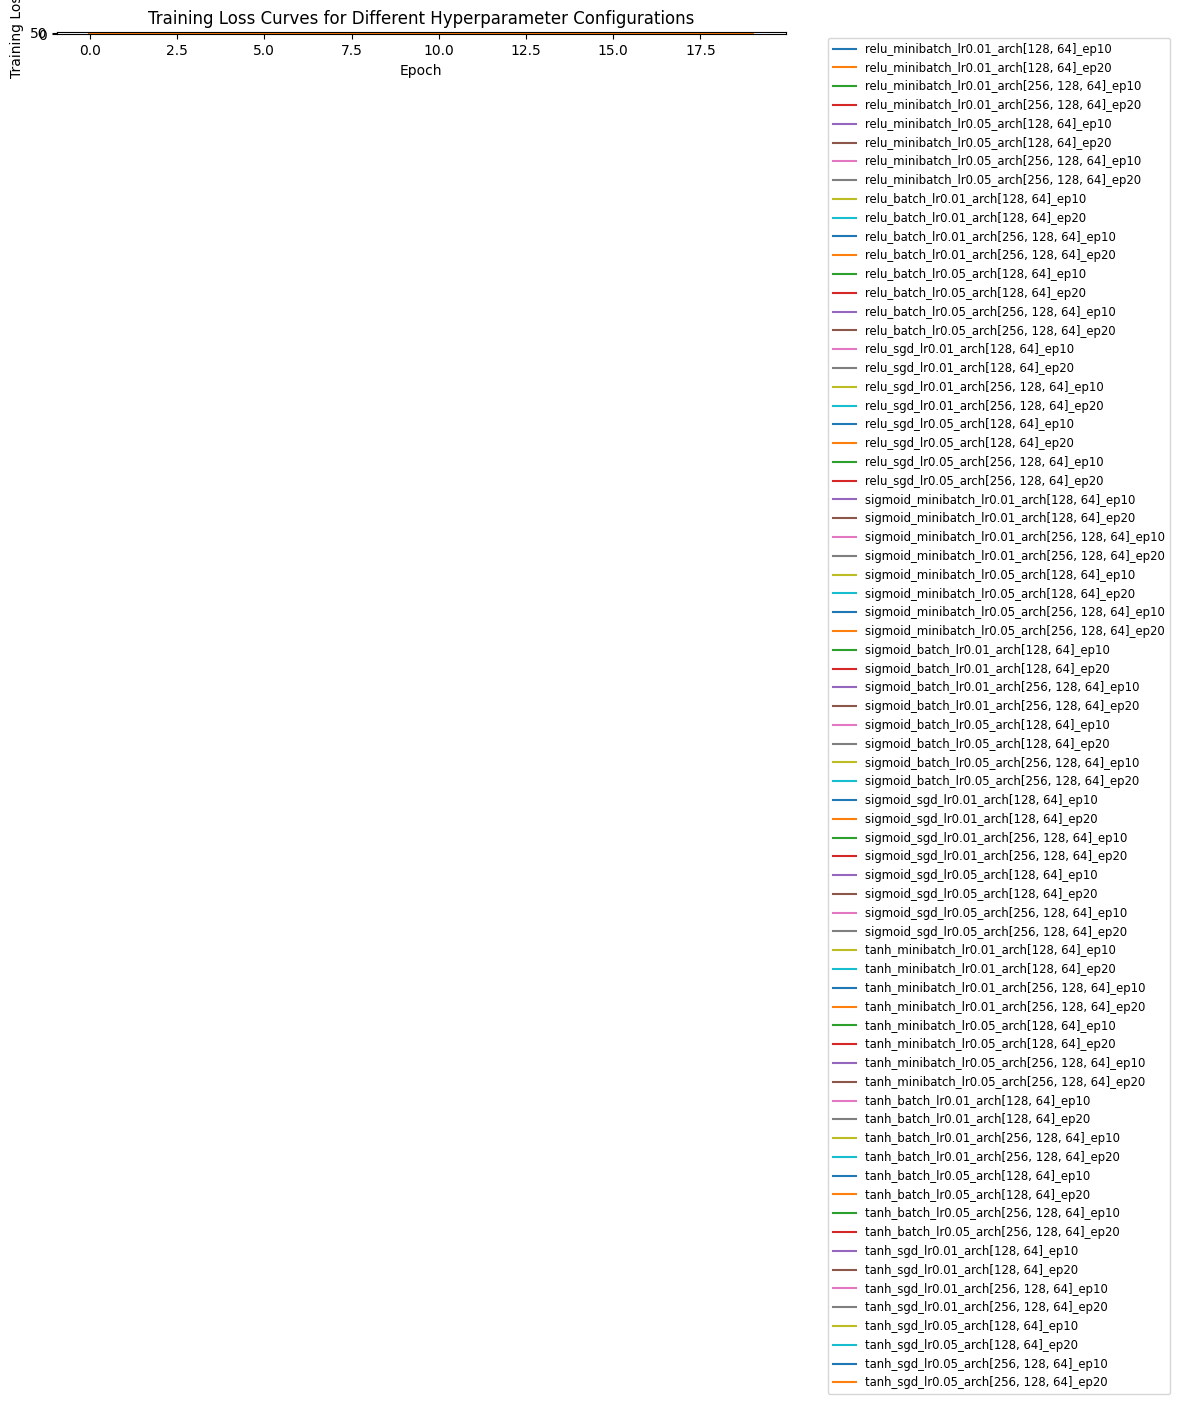

In [11]:
# Preprocess training data
# train_csv_path = 'train.csv'  # update with your training CSV path
# X_train, X_val, Y_train, Y_val, vocab, idf, label_mapping = preprocess_data(train_csv_path, max_features=5000, test_size=0.2)
# input_size = X_train.shape[1]
# output_size = Y_train.shape[1]

# Preprocess test data (assumes test CSV has "document" and optionally "category")
test_csv_path = '/content/drive/MyDrive/news-article/test.csv'  # update with your test CSV path
X_test, df_test, Y_test = preprocess_test_data(test_csv_path, vocab, idf)
if Y_test is None:
    print("Test labels not found; evaluation metrics on test set cannot be computed.")
    exit(1)

# Define extended hyperparameter grid
activation_options = ['relu', 'sigmoid', 'tanh']
optimizer_options = ['minibatch', 'batch','sgd']
learning_rate_options = [0.01, 0.05]
architecture_options = [[128, 64], [256, 128, 64]]
epoch_options = [10, 20]

experiment_results = []

for act in activation_options:
    for opt in optimizer_options:
        for lr in learning_rate_options:
            for arch in architecture_options:
                for epochs in epoch_options:
                    print(f"\n=== Experiment: Activation={act}, Optimizer={opt}, Learning Rate={lr}, Architecture={arch}, Epochs={epochs} ===")

                    # Initialize and train the model for the current configuration
                    mlp_model = MLP(
                        input_size=input_size,
                        output_size=output_size,
                        hidden_layers=arch,
                        activation=act,
                        learning_rate=lr,
                        optimizer=opt,
                        verbose=False
                    )

                    history = mlp_model.train(X_train, Y_train, epochs=epochs, batch_size=32, X_val=X_val, Y_val=Y_val)

                    # Evaluate on the test set
                    test_preds = mlp_model.predict(X_test)
                    test_loss = mlp_model.compute_loss(mlp_model.forward(X_test)[0][-1], Y_test)
                    test_hamming = compute_hamming_loss(Y_test, test_preds)
                    test_acc = compute_accuracy(Y_test, test_preds)

                    temp_results={
                        'activation': act,
                        'optimizer': opt,
                        'learning_rate': lr,
                        'architecture': arch,
                        'epochs': epochs,
                        'test_loss': test_loss,
                        'test_hamming': test_hamming,
                        'test_accuracy': test_acc,
                        'history': history
                    }

                    # Record the experiment results
                    experiment_results.append(temp_results)

                    for key, value in temp_results.items():
                        if key == 'test_loss' or key == 'test_hamming' or key == 'test_accuracy':
                            print(f"{key}: {value}")


# Order experiments by test accuracy (subset accuracy)
experiment_results_sorted = sorted(experiment_results, key=lambda x: x['test_accuracy'], reverse=True)

print("\n=== Final Evaluation Metrics (ordered by test accuracy) ===")
for res in experiment_results_sorted:
    print(f"Activation: {res['activation']}, Optimizer: {res['optimizer']}, Learning Rate: {res['learning_rate']}, Architecture: {res['architecture']}, Epochs: {res['epochs']}, Test Loss: {res['test_loss']:.4f}, Hamming Loss: {res['test_hamming']:.4f}, Accuracy: {res['test_accuracy']:.4f}")

# Identify the best configuration (highest test accuracy)
best_config = experiment_results_sorted[0]
print(f"\nBest Configuration: Activation = {best_config['activation']}, Optimizer = {best_config['optimizer']}, Learning Rate = {best_config['learning_rate']}, Architecture = {best_config['architecture']}, Epochs = {best_config['epochs']}")

# Plot training loss curves for each configuration (optional)
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
for res in experiment_results:
    history = res['history']
    label = f"{res['activation']}_{res['optimizer']}_lr{res['learning_rate']}_arch{res['architecture']}_ep{res['epochs']}"
    plt.plot(history['loss'], label=label)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Curves for Different Hyperparameter Configurations')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()


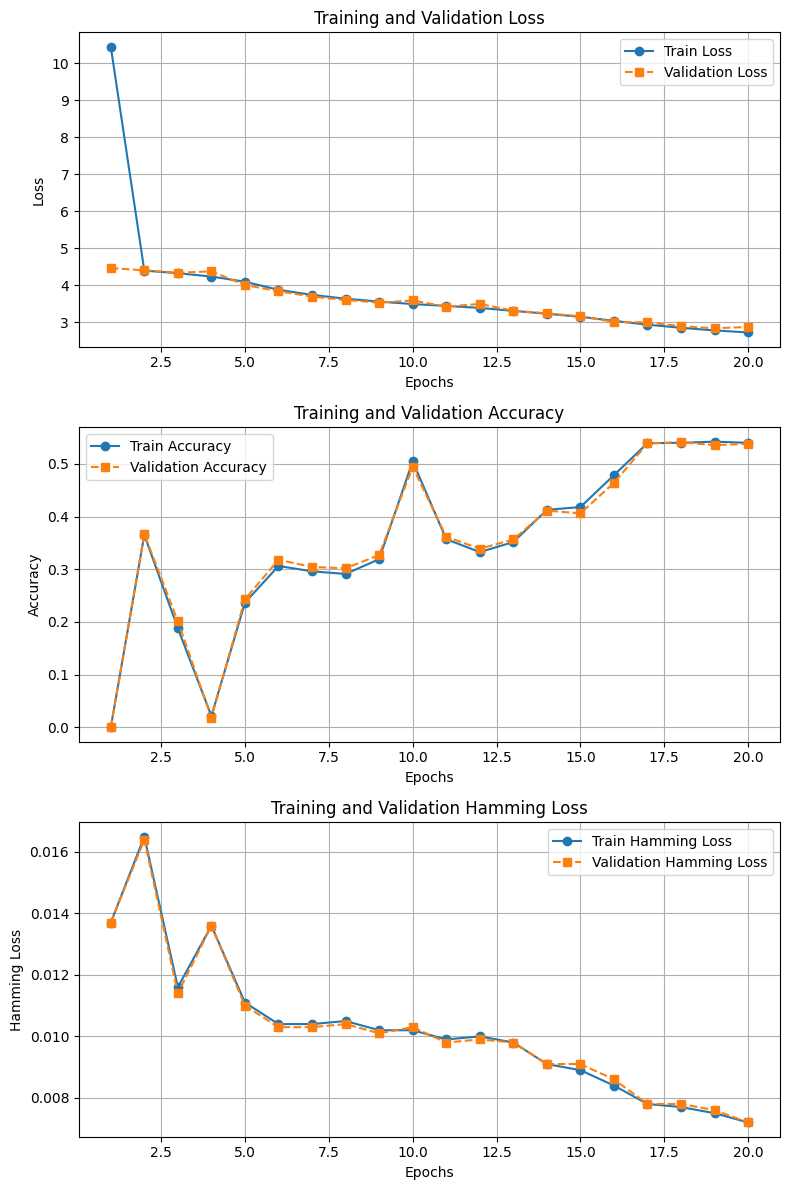

In [6]:
import matplotlib.pyplot as plt

# Defining epochs
epochs = list(range(1, 21))

# Given loss values for each epoch
train_loss = [10.4434, 4.3953, 4.3256, 4.2346, 4.0947, 3.8771, 3.7395, 3.6373, 3.5586, 3.4921, 
              3.4416, 3.3882, 3.3084, 3.2306, 3.1478, 3.0385, 2.9350, 2.8514, 2.7803, 2.7259]
val_loss = [4.4636, 4.4037, 4.3383, 4.3747, 4.0068, 3.8385, 3.6936, 3.6009, 3.5303, 3.5887, 
            3.4234, 3.4949, 3.3136, 3.2419, 3.1616, 3.0119, 2.9956, 2.8943, 2.8384, 2.8741]

# Given accuracy values
train_acc = [0.0000, 0.3652, 0.1879, 0.0217, 0.2367, 0.3062, 0.2961, 0.2911, 0.3191, 0.5049, 
             0.3570, 0.3326, 0.3516, 0.4127, 0.4180, 0.4785, 0.5392, 0.5398, 0.5421, 0.5398]
val_acc = [0.0000, 0.3668, 0.2014, 0.0187, 0.2432, 0.3179, 0.3044, 0.3018, 0.3269, 0.4942, 
           0.3616, 0.3391, 0.3565, 0.4112, 0.4060, 0.4640, 0.5386, 0.5412, 0.5354, 0.5380]

# Given Hamming loss values
train_hamming = [0.0137, 0.0165, 0.0116, 0.0136, 0.0111, 0.0104, 0.0104, 0.0105, 0.0102, 0.0102, 
                 0.0099, 0.0100, 0.0098, 0.0091, 0.0089, 0.0084, 0.0078, 0.0077, 0.0075, 0.0072]
val_hamming = [0.0137, 0.0164, 0.0114, 0.0136, 0.0110, 0.0103, 0.0103, 0.0104, 0.0101, 0.0103, 
               0.0098, 0.0099, 0.0098, 0.0091, 0.0091, 0.0086, 0.0078, 0.0078, 0.0076, 0.0072]

# Create subplots for loss, accuracy, and hamming loss
fig, axes = plt.subplots(3, 1, figsize=(8, 12))

# Loss plot
axes[0].plot(epochs, train_loss, label='Train Loss', marker='o', linestyle='-')
axes[0].plot(epochs, val_loss, label='Validation Loss', marker='s', linestyle='--')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy plot
axes[1].plot(epochs, train_acc, label='Train Accuracy', marker='o', linestyle='-')
axes[1].plot(epochs, val_acc, label='Validation Accuracy', marker='s', linestyle='--')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

# Hamming Loss plot
axes[2].plot(epochs, train_hamming, label='Train Hamming Loss', marker='o', linestyle='-')
axes[2].plot(epochs, val_hamming, label='Validation Hamming Loss', marker='s', linestyle='--')
axes[2].set_xlabel('Epochs')
axes[2].set_ylabel('Hamming Loss')
axes[2].set_title('Training and Validation Hamming Loss')
axes[2].legend()
axes[2].grid(True)

# Show plots
plt.tight_layout()
plt.show()


In [ ]:
# import numpy as np
# import torch
# import torch

# # Manually implemented activation functions and their derivatives

# def sigmoid(z):
#     return 1 / (1 + np.exp(-z))

# def sigmoid_deriv(a):
#     return a * (1 - a)

# def tanh(z):
#     return np.tanh(z)

# def tanh_deriv(a):
#     return 1 - np.power(a, 2)

# def relu(z):
#     return np.maximum(0, z)

# def relu_deriv(z):
#     return (z > 0).astype(float)

# # Custom MLP class (not inheriting from any parent class)

# class MLP:
#     def __init__(self, input_size, output_size, hidden_layers=[100], activation='relu', learning_rate=0.01, optimizer='sgd'):
#         """
#         Initialize the MLP model with weights and biases, along with the chosen activation function.
#         """
#         self.learning_rate = learning_rate
#         self.optimizer = optimizer.lower()

#         # Choose activation function
#         if activation.lower() == 'sigmoid':
#             self.activation_func = sigmoid
#             self.activation_deriv = sigmoid_deriv
#         elif activation.lower() == 'tanh':
#             self.activation_func = tanh
#             self.activation_deriv = tanh_deriv
#         elif activation.lower() == 'relu':
#             self.activation_func = relu
#             self.activation_deriv = relu_deriv
#         else:
#             raise ValueError("Unsupported activation function")

#         # Build the model architecture
#         layer_sizes = [input_size] + hidden_layers + [output_size]
#         self.num_layers = len(layer_sizes)
#         self.weights = []
#         self.biases = []

#         # Initialize weights and biases for each layer
#         for i in range(self.num_layers - 1):
#             W = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(2 / layer_sizes[i])  # He initialization
#             b = np.zeros((1, layer_sizes[i+1]))
#             self.weights.append(W)
#             self.biases.append(b)

#     def forward(self, X):
#         """Forward propagation"""
#         a = X
#         activations = [a]
#         zs = []  # Store the weighted inputs (z values) for each layer
#         for i in range(len(self.weights) - 1):
#             z = np.dot(a, self.weights[i]) + self.biases[i]
#             a = self.activation_func(z)
#             zs.append(z)
#             activations.append(a)
#         # Last layer uses sigmoid activation for multi-label classification
#         z = np.dot(a, self.weights[-1]) + self.biases[-1]
#         a = sigmoid(z)
#         zs.append(z)
#         activations.append(a)
#         return activations, zs

#     def compute_loss(self, Y_hat, Y):
#         """Binary cross-entropy loss"""
#         m = Y.shape[0]
#         epsilon = 1e-8
#         loss = -np.sum(Y * np.log(Y_hat + epsilon) + (1 - Y) * np.log(1 - Y_hat + epsilon)) / m
#         return loss

#     def backward(self, activations, zs, X, Y):
#         """Backward propagation"""
#         m = Y.shape[0]
#         grads_W = [None] * len(self.weights)
#         grads_b = [None] * len(self.biases)

#         # Start from the output layer
#         aL = activations[-1]
#         delta = (aL - Y)  # Derivative for binary cross-entropy with sigmoid output
#         grads_W[-1] = np.dot(activations[-2].T, delta) / m
#         grads_b[-1] = np.sum(delta, axis=0, keepdims=True) / m

#         # Backpropagate through hidden layers
#         for l in range(2, self.num_layers):
#             z = zs[-l]
#             d_activation = self.activation_deriv(activations[-l])
#             delta = np.dot(delta, self.weights[-l+1].T) * d_activation
#             grads_W[-l] = np.dot(activations[-l-1].T, delta) / m
#             grads_b[-l] = np.sum(delta, axis=0, keepdims=True) / m

#         return grads_W, grads_b

#     def update_parameters(self, grads_W, grads_b):
#         """Update parameters using gradient descent"""
#         for i in range(len(self.weights)):
#             self.weights[i] -= self.learning_rate * grads_W[i]
#             self.biases[i] -= self.learning_rate * grads_b[i]

#     def train(self, X, Y, epochs=100, batch_size=32, X_val=None, Y_val=None):
#         """Train the MLP"""
#         m = X.shape[0]
#         history = {
#             'loss': [],
#             'train_hamming_loss': [],
#             'train_accuracy': [],
#             'val_loss': [],
#             'val_hamming_loss': [],
#             'val_accuracy': []
#         }

#         for epoch in range(epochs):
#             indices = np.arange(m)
#             np.random.shuffle(indices)
#             X_shuffled = X[indices]
#             Y_shuffled = Y[indices]

#             if self.optimizer == 'batch':
#                 activations, zs = self.forward(X_shuffled)
#                 loss = self.compute_loss(activations[-1], Y_shuffled)
#                 grads_W, grads_b = self.backward(activations, zs, X_shuffled, Y_shuffled)
#                 self.update_parameters(grads_W, grads_b)
#             elif self.optimizer == 'sgd':
#                 losses = []
#                 for i in range(m):
#                     xi = X_shuffled[i:i+1]
#                     yi = Y_shuffled[i:i+1]
#                     activations, zs = self.forward(xi)
#                     loss_i = self.compute_loss(activations[-1], yi)
#                     losses.append(loss_i)
#                     grads_W, grads_b = self.backward(activations, zs, xi, yi)
#                     self.update_parameters(grads_W, grads_b)
#                 loss = np.mean(losses)
#             elif self.optimizer == 'minibatch':
#                 num_batches = int(np.ceil(m / batch_size))
#                 losses = []
#                 for i in range(num_batches):
#                     start = i * batch_size
#                     end = min(start + batch_size, m)
#                     xi = X_shuffled[start:end]
#                     yi = Y_shuffled[start:end]
#                     activations, zs = self.forward(xi)
#                     loss_i = self.compute_loss(activations[-1], yi)
#                     losses.append(loss_i)
#                     grads_W, grads_b = self.backward(activations, zs, xi, yi)
#                     self.update_parameters(grads_W, grads_b)
#                 loss = np.mean(losses)
#             else:
#                 raise ValueError("Unsupported optimizer type")

#             # Compute training metrics on the entire training set
#             train_preds = self.predict(X)
#             train_hamming = compute_hamming_loss(Y, train_preds)
#             train_acc = compute_accuracy(Y, train_preds)

#             history['loss'].append(loss)
#             history['train_hamming_loss'].append(train_hamming)
#             history['train_accuracy'].append(train_acc)

#             # Compute validation metrics if available
#             if X_val is not None and Y_val is not None:
#                 val_preds = self.predict(X_val)
#                 val_loss = self.compute_loss(self.forward(X_val)[0][-1], Y_val)
#                 val_hamming = compute_hamming_loss(Y_val, val_preds)
#                 val_acc = compute_accuracy(Y_val, val_preds)
#                 history['val_loss'].append(val_loss)
#                 history['val_hamming_loss'].append(val_hamming)
#                 history['val_accuracy'].append(val_acc)
#                 print(f"Epoch {epoch+1}/{epochs} - loss: {loss:.4f} - train_hamming: {train_hamming:.4f} - train_acc: {train_acc:.4f} - val_loss: {val_loss:.4f} - val_hamming: {val_hamming:.4f} - val_acc: {val_acc:.4f}")
#             else:
#                 print(f"Epoch {epoch+1}/{epochs} - loss: {loss:.4f} - train_hamming: {train_hamming:.4f} - train_acc: {train_acc:.4f}")
#         return history

#     def predict(self, X, threshold=0.5):
#         """Predict multi-label outputs using the trained model"""
#         activations, _ = self.forward(X)
#         predictions = (activations[-1] >= threshold).astype(int)
#         return predictions


In [ ]:
# import numpy as np

# def compute_hamming_loss(Y_true, Y_pred):
#     """
#     Compute Hamming loss, which is the fraction of labels that are incorrectly predicted.
#     Hamming loss = (1 / N) * sum of (Y_true != Y_pred)
#     where N is the number of samples, and each label is treated independently.

#     Parameters:
#     - Y_true: True labels (numpy array of shape [num_samples, num_labels])
#     - Y_pred: Predicted labels (numpy array of shape [num_samples, num_labels])

#     Returns:
#     - Hamming loss: float value
#     """
#     # Check if Y_true and Y_pred have the same shape
#     if Y_true.shape != Y_pred.shape:
#         raise ValueError("Y_true and Y_pred must have the same shape")

#     # Compute the number of misclassified labels
#     incorrect = np.sum(Y_true != Y_pred)

#     # Normalize by the total number of labels
#     total_labels = Y_true.size
#     hamming_loss = incorrect / total_labels

#     return hamming_loss

# def compute_accuracy(Y_true, Y_pred):
#     """
#     Compute accuracy, which is the fraction of samples that are correctly predicted.
#     Accuracy = (1 / N) * sum of (Y_true == Y_pred)

#     Parameters:
#     - Y_true: True labels (numpy array of shape [num_samples, num_labels])
#     - Y_pred: Predicted labels (numpy array of shape [num_samples, num_labels])

#     Returns:
#     - Accuracy: float value
#     """
#     # Check if Y_true and Y_pred have the same shape
#     if Y_true.shape != Y_pred.shape:
#         raise ValueError("Y_true and Y_pred must have the same shape")

#     # Compute the number of correctly predicted labels
#     correct = np.sum(Y_true == Y_pred)

#     # Normalize by the total number of labels
#     total_labels = Y_true.size
#     accuracy = correct / total_labels

#     return accuracy


In [ ]:
# # ----------------------------
# # 1. Data Preprocessing
# # ----------------------------

# def clean_text(text):
#     """Lowercase and remove non-alphanumeric characters."""
#     text = text.lower()
#     text = re.sub(r'[^a-z0-9\s]', '', text)
#     return text

# def tokenize(text):
#     """Split text by whitespace and remove stopwords."""
#     tokens = text.split()
#     # Remove stopwords
#     tokens = [token for token in tokens if token not in STOPWORDS]
#     return tokens

# def build_vocabulary(documents, max_features=5000):
#     """Build vocabulary of the top max_features tokens from the documents."""
#     counter = Counter()
#     for doc in documents:
#         tokens = tokenize(doc)
#         counter.update(tokens)
#     vocab = {word: i for i, (word, _) in enumerate(counter.most_common(max_features))}
#     return vocab

# def compute_idf(documents, vocab):
#     """Compute inverse document frequency for each word in vocab."""
#     N = len(documents)
#     df = np.zeros(len(vocab))
#     for doc in documents:
#         tokens = set(tokenize(doc))
#         for token in tokens:
#             if token in vocab:
#                 df[vocab[token]] += 1
#     idf = np.log((N + 1) / (df + 1)) + 1
#     return idf

# def compute_tf_idf(documents, vocab, idf):
#     """Compute TF-IDF for each document given a vocabulary and idf vector."""
#     X = np.zeros((len(documents), len(vocab)))
#     for i, doc in enumerate(documents):
#         tokens = tokenize(doc)
#         if len(tokens) == 0:
#             continue
#         tf_counter = Counter(tokens)
#         total_count = len(tokens)
#         for token, count in tf_counter.items():
#             if token in vocab:
#                 j = vocab[token]
#                 tf = count / total_count
#                 X[i, j] = tf * idf[j]
#     return X

# def multi_label_binarize(labels_list):
#     """Convert list of comma-separated labels to a binary matrix."""
#     label_set = set()
#     split_labels = []
#     for labels in labels_list:
#         topics = [label.strip() for label in labels.split(',') if label.strip()]
#         split_labels.append(topics)
#         label_set.update(topics)
#     label_list = sorted(list(label_set))
#     label_mapping = {label: idx for idx, label in enumerate(label_list)}
#     Y = np.zeros((len(labels_list), len(label_list)))
#     for i, topics in enumerate(split_labels):
#         for topic in topics:
#             if topic in label_mapping:
#                 Y[i, label_mapping[topic]] = 1
#     return Y, label_mapping


# def preprocess_data(csv_path, max_features=5000, test_size=0.2):
#     """Load CSV, clean documents, compute TF-IDF, binarize labels,
#        and split into training and validation sets."""
#     df = pd.read_csv(csv_path)
#     df.dropna(subset=['document', 'category'], inplace=True)
#     df['document'] = df['document'].apply(clean_text)

#     documents = df['document'].tolist()
#     labels_list = df['category'].tolist()

#     vocab = build_vocabulary(documents, max_features=max_features)
#     idf = compute_idf(documents, vocab)
#     X = compute_tf_idf(documents, vocab, idf)
#     Y, label_mapping = multi_label_binarize(labels_list)

#     # Convert to PyTorch tensors
#     X = torch.tensor(X, dtype=torch.float32)
#     Y = torch.tensor(Y, dtype=torch.float32)

#     # Split into train and validation sets
#     X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=test_size, random_state=42)
#     return X_train, X_val, Y_train, Y_val, vocab, label_mapping


In [1]:
# # Preprocessing and training as before:
# csv_path = '/content/drive/MyDrive/news-article/train.csv'  # Path to your training CSV file
# X_train, X_val, Y_train, Y_val, vocab, label_mapping = preprocess_data(csv_path, max_features=5000, test_size=0.2)

# # 'idf' computed during training:
# documents_train = pd.read_csv(csv_path)['document'].dropna().apply(clean_text).tolist()
# idf = compute_idf(documents_train, vocab)

# input_size = X_train.shape[1]
# output_size = Y_train.shape[1]

# mlp = MLP(input_size=input_size, output_size=output_size, hidden_layers=[256,128,64], activation='relu', learning_rate=0.01,optimizer='minibatch')

# history = mlp.train(X_train, Y_train, epochs=100, batch_size=32, X_val=X_val, Y_val=Y_val)

# # --- Testing on new data ---
# test_csv_path = '/content/drive/MyDrive/news-article/test.csv'  # Path to your test CSV file
# X_test, df_test,Y_test = preprocess_test_data(test_csv_path, vocab, idf)

# test_predictions = mlp.predict(X_test)
# print("Sample predictions on test set:")
# print(np.sum(test_predictions[:10], axis=1))

# # Optional: If the test data has true labels in a "category" column, compute test metrics.
# test_hamming = compute_hamming_loss(Y_test, test_predictions)
# test_acc = compute_accuracy(Y_test, test_predictions)
# print(f"Test Hamming Loss: {test_hamming:.4f}, Test Accuracy: {test_acc:.4f}")
